In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T

import math
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch.utils.data.dataloader as dataloader

In [2]:
batch_size = 128
num_epochs = 30
learning_rate = 1e-4
best_valid_acc = 0
data_set_root = "../../datasets"

In [3]:
start_from_checkpoint = False
save_dir = '../data/Models'
model_name = 'SelfALexNet'

In [4]:
gpu_indx=0
device=torch.device(gpu_indx if torch.cuda.is_available() else 'mps')

# Data Augmentation
về cái transform để phù hợp với data tôi tham khảo ở link [https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5](https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5)

In [6]:
train_transform =T.Compose([T.Resize(227),
                      T.ToTensor(),
                      T.RandomResizedCrop(size=(224, 224), antialias=True),
                      T.RandomHorizontalFlip(p=0.5),
                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

testval_transform =T.Compose([T.Resize(227),
                      T.ToTensor(),
                      T.RandomResizedCrop(size=(224, 224), antialias=True),
                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

In [7]:
# !pip install split-folders

In [8]:
import splitfolders
import os

In [9]:
path= "/Users/nguyenthephong/Desktop/Okay this is ML serious/Pytorch/SOme self implemented model practice/Vtuber"
print(os.listdir(path))

['.DS_Store', 'Suisei', 'Azki']


In [10]:
for folder in os.listdir(path):
    if not folder.startswith('.') and os.path.isdir(os.path.join(path,folder)):
        print(folder)

Suisei
Azki


In [11]:
splitfolders.ratio(path,seed=1337, output="Vtuber_splitted", ratio=(0.6, 0.2, 0.2)) #train, test, val wwill go to new folder in output

Copying files: 600 files [00:00, 957.01 files/s] 


In [12]:
print(os.getcwd())

/Users/nguyenthephong/Desktop/Okay this is ML serious/Pytorch/SOme self implemented model practice


In [13]:
from torchvision.datasets import ImageFolder
train= "/Users/nguyenthephong/Desktop/Okay this is ML serious/Pytorch/SOme self implemented model practice/Vtuber_splitted/train"
train_path= ImageFolder(root=train,transform=train_transform)
print(f'Number of training examples: {len(train_path)}')

Number of training examples: 360


In [14]:
test= "/Users/nguyenthephong/Desktop/Okay this is ML serious/Pytorch/SOme self implemented model practice/Vtuber_splitted/test"
test_path= ImageFolder(root=test,transform=testval_transform)
print(f'Number of examples: {len(test_path)}')
val= "/Users/nguyenthephong/Desktop/Okay this is ML serious/Pytorch/SOme self implemented model practice/Vtuber_splitted/val"
val_path= ImageFolder(root=val,transform=testval_transform)
print(f'Number of examples: {len(val_path)}')

Number of examples: 120
Number of examples: 120


In [23]:
train_loader = dataloader.DataLoader(train_path, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(test_path, batch_size=batch_size)
test_loader  = dataloader.DataLoader(val_path, batch_size=batch_size)

In [25]:
class SelfALexNet(nn.Module):
    def __init__(self, image_size_color,classes):
        super(SelfALexNet, self).__init__()
        self.conv1=nn.Conv2d(image_size_color, 96, kernel_size=11,stride=4)
        self.maxpool1=nn.MaxPool2d(kernel_size=3,stride=2)

        self.conv2=nn.Conv2d(96, 256, kernel_size=5,stride=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=3,stride=2)

        self.conv3=nn.Conv2d(256, 384, kernel_size=3,stride=1)
        self.conv4=nn.Conv2d(384, 384, kernel_size=3,stride=1)
        
        self.conv5=nn.Conv2d(384, 256, kernel_size=3,stride=1)
        self.maxpool3=nn.MaxPool2d(kernel_size=3,stride=2)
        
        self.fc1=nn.Linear(9216,4096)
        self.fc2=nn.Linear(4096,4096)
        self.fc3=nn.Linear(4096,classes)
    def forward(self, x):
        x= F.relu(self.conv1(x))
        x= F.relu(self.maxpool1(x))
        x= F.relu(self.conv2(x))
        x= F.relu(self.maxpool2(x))
        x= F.relu(self.conv3(x))
        x= F.relu(self.conv4(x))
        x= F.relu(self.conv5(x))
        x= F.relu(self.maxpool3(x))
        x=torch.flatten(x) 
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= F.softmax(self.fc3(x))
        return x

In [27]:
model=SelfALexNet(227,2)
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([[[[-5.0081e-03,  1.2246e-03, -3.0952e-03,  ...,  3.8189e-03,
           -2.5140e-04, -4.7765e-03],
          [-3.6192e-03,  1.6864e-03,  5.9042e-04,  ...,  2.8075e-03,
            3.8558e-04,  1.1678e-03],
          [-5.4372e-03, -2.2934e-03,  5.7393e-03,  ..., -5.4573e-03,
           -3.3671e-04, -2.0120e-03],
          ...,
          [-3.5168e-03, -1.7909e-03,  4.5097e-03,  ..., -5.6978e-04,
            1.0893e-04,  4.3662e-03],
          [-5.9128e-03,  5.4131e-03, -2.3600e-03,  ..., -5.5633e-03,
           -9.9583e-04,  2.6992e-03],
          [-1.0813e-03,  1.9670e-03, -2.5036e-03,  ...,  3.8756e-03,
           -5.7775e-03, -5.8475e-04]],

         [[ 1.6800e-03,  5.2841e-03, -3.4196e-03,  ...,  2.7568e-03,
            4.8672e-03,  6.2012e-04],
          [ 5.1278e-03, -5.2371e-04,  3.1834e-03,  ..., -3.9152e-03,
           -1.9615e-03,  1.3081e-03],
          [-2.0536e-03, -4.3767e-03,  8.5981e-05,  ..., -4.1689e-03,
            4.9424e-03,  8.7344e-04]

In [29]:
num_params = 0
for param in model.parameters():
    num_params += param.flatten().shape[0]
print("This model has %d (approximately %d Million) Parameters!" % (num_params, num_params//1e6))

This model has 60891522 (approximately 60 Million) Parameters!


In [31]:
# Create a dataloader itterable object
dataiter = iter(test_loader)
# Sample from the itterable object
test_images, test_labels = next(dataiter)

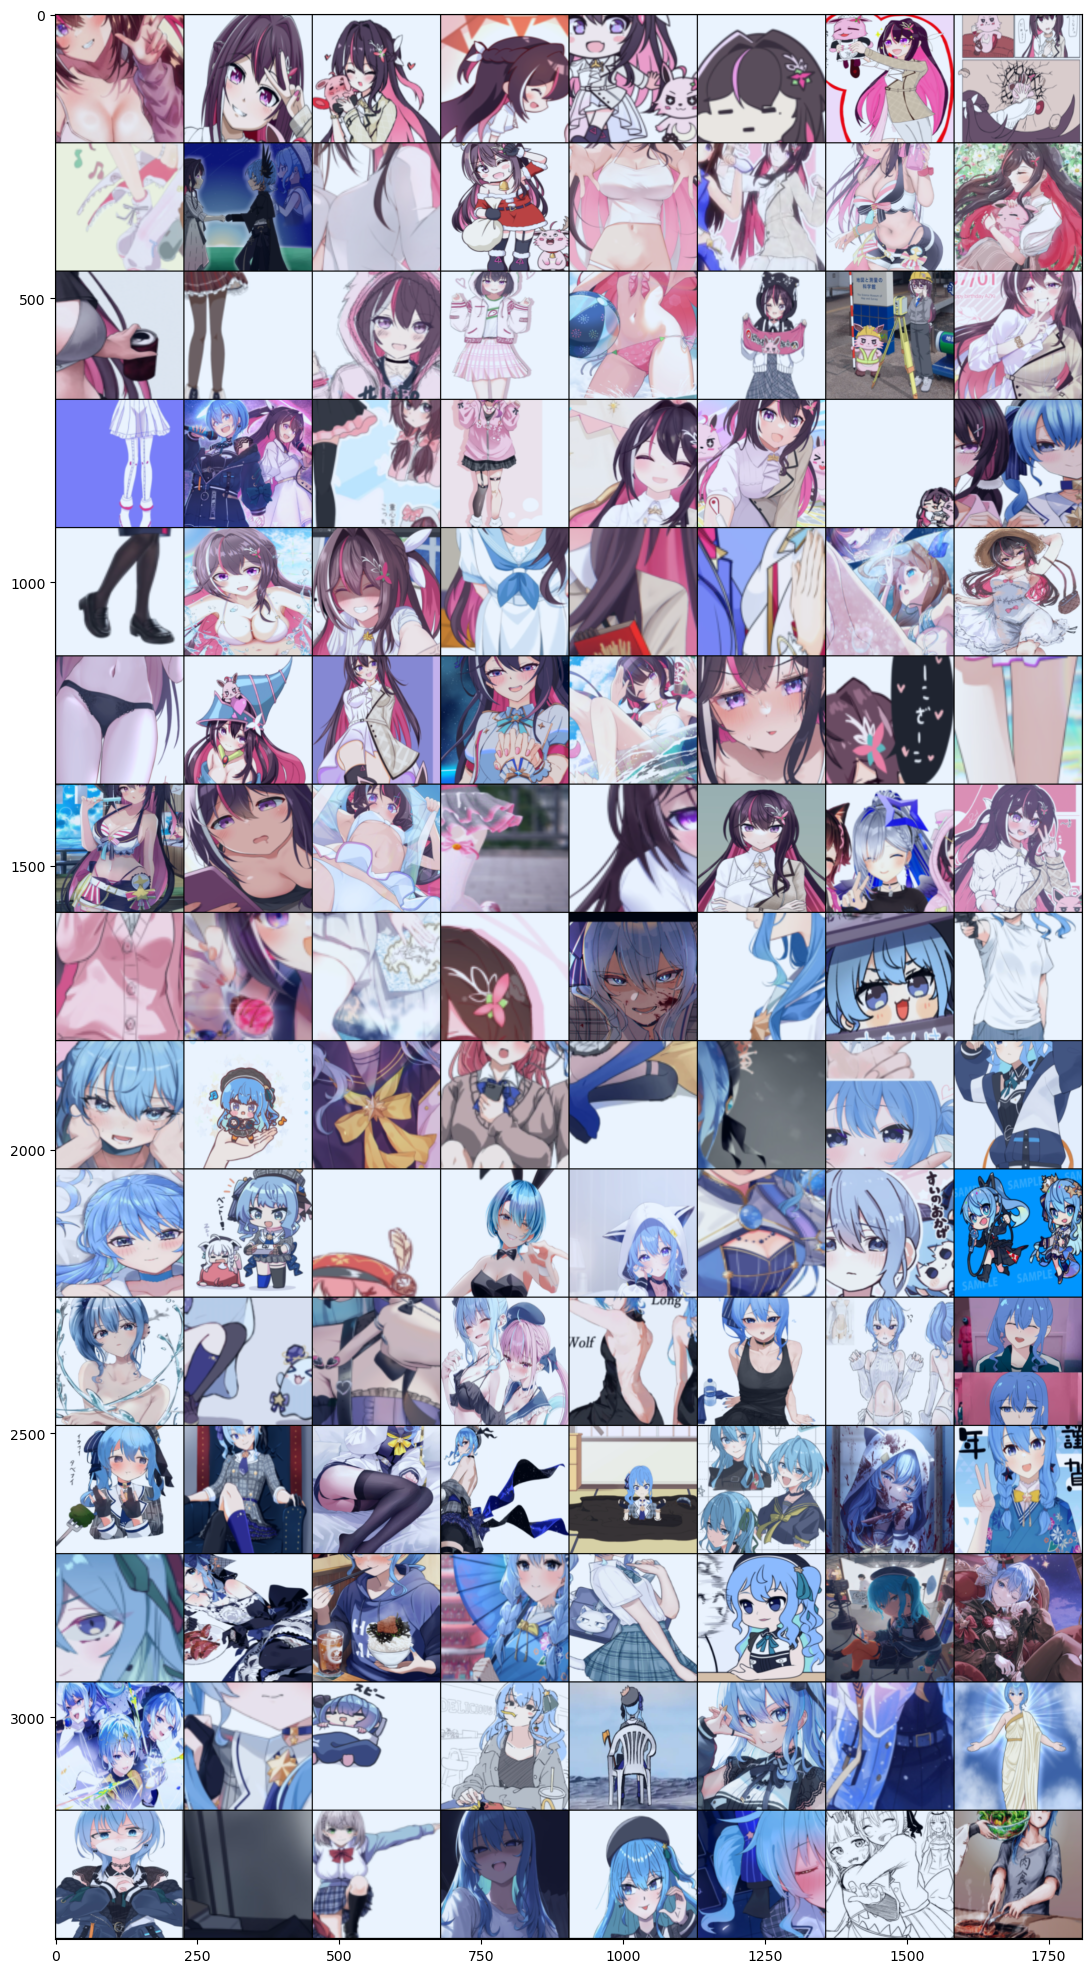

In [43]:
plt.figure(figsize = (50,25))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))